In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from datetime import datetime
from jupyterthemes import jtplot
jtplot.style()
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf


In [2]:
np.random.seed(123)
tf.random.set_seed(123)

Extracting the data from yahoo finance

In [3]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
#Data start date
end=datetime.now()
#
start=datetime(end.year-1,end.month,end.day)
#obtaining the data for each stock
for stock in tech_list:
    globals()[stock]=yf.download(stock,start,end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
companies=[AAPL,GOOG,MSFT,AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]
for company, comp_name in zip(companies,company_name):
    company['company_name']=comp_name

In [5]:
df=pd.concat(companies,axis=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-03-24,171.059998,174.139999,170.210007,174.070007,173.021881,90131400,APPLE
2022-03-25,173.880005,175.279999,172.750000,174.720001,173.667969,80546200,APPLE
2022-03-28,172.169998,175.729996,172.000000,175.600006,174.542679,90371900,APPLE
2022-03-29,176.690002,179.009995,176.339996,178.960007,177.882446,100589400,APPLE
2022-03-30,178.550003,179.610001,176.699997,177.770004,176.699615,92633200,APPLE


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1.004000e+03
mean,156.979235,159.203082,154.813957,157.042003,156.578026,5.365975e+07
std,63.124845,63.724819,62.449428,63.117968,62.525781,3.211238e+07
min,82.800003,83.480003,81.430000,81.820000,81.820000,8.567800e+06
25%,107.497377,109.792263,105.835625,107.582502,107.582502,2.699172e+07
50%,139.217003,141.635002,137.230003,138.924995,138.488464,4.771220e+07
75%,188.300003,189.810001,185.882496,187.782505,186.690365,7.244945e+07
max,313.910004,315.950012,311.579987,315.410004,312.345795,2.726620e+08


In [7]:
print(AAPL.describe())
print(AAPL.info())
#It is observed that there are only 252 observations out of 261, so the difference in days are holidays

             Open        High         Low       Close   Adj Close  \
count  251.000000  251.000000  251.000000  251.000000  251.000000   
mean   149.948965  152.028287  148.046932  150.108167  149.641279   
std     11.778075   11.675151   11.812200   11.766763   11.623834   
min    126.010002  127.769997  124.169998  125.019997  124.829399   
25%    142.110001  143.854996  139.949997  142.464996  141.973427   
50%    148.869995  150.919998  147.240005  149.350006  148.910004   
75%    156.275002  158.154999  154.164993  156.779999  155.852943   
max    178.550003  179.610001  176.699997  178.960007  177.882446   

             Volume  
count  2.510000e+02  
mean   8.227013e+07  
std    2.351118e+07  
min    3.519590e+07  
25%    6.776600e+07  
50%    7.703420e+07  
75%    9.025165e+07  
max    1.826020e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-24 to 2023-03-23
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------   

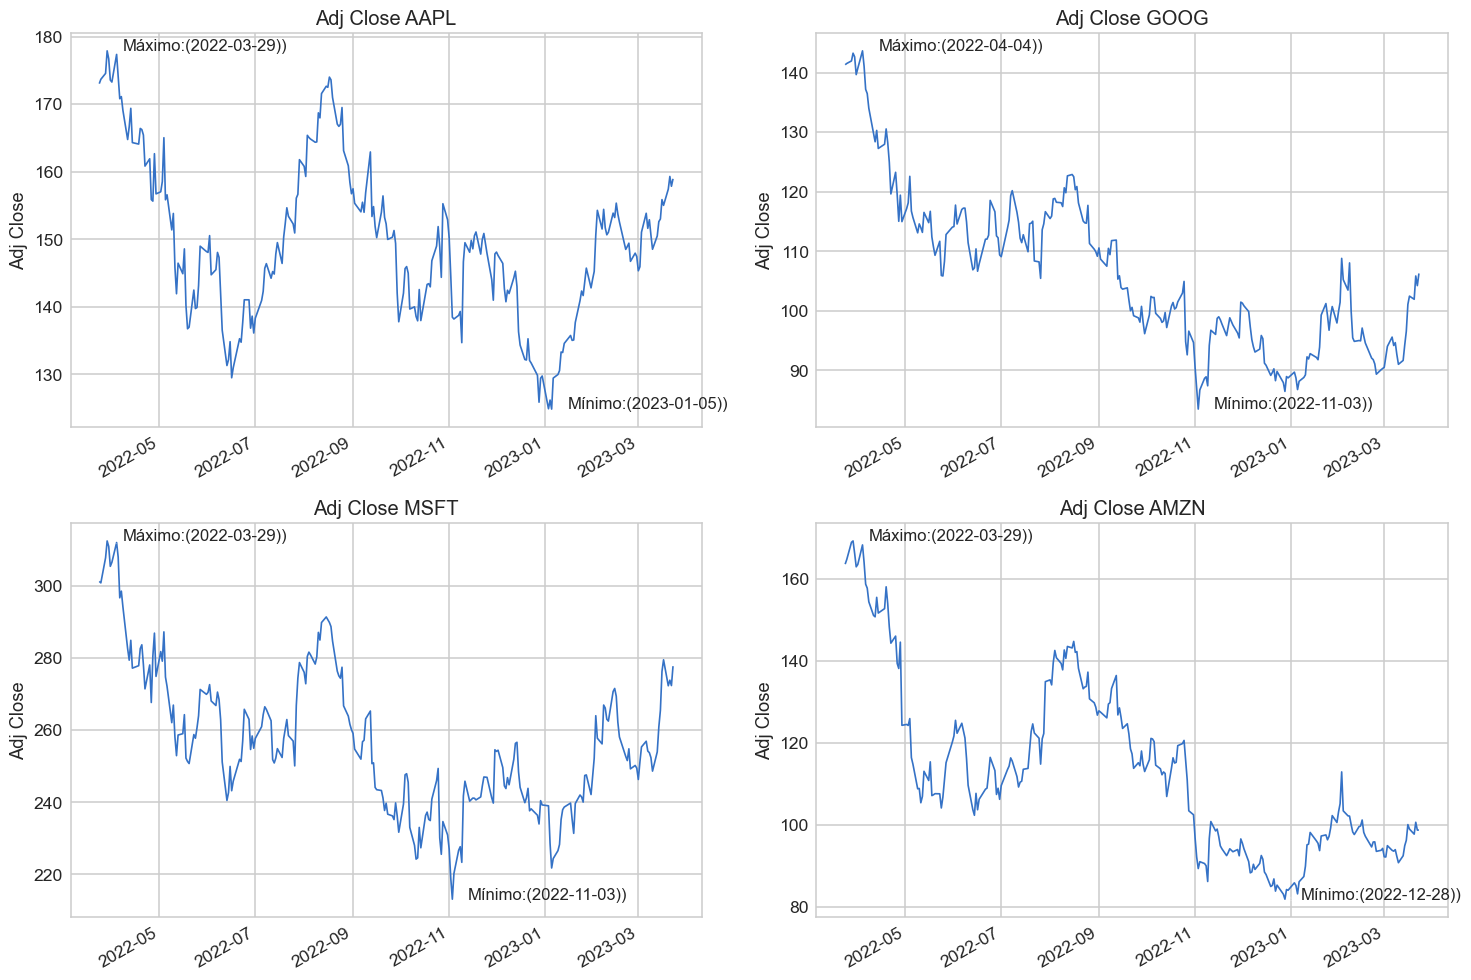

In [8]:
# Let's see a historical view of the closing price
jtplot.style()
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(companies,1):
    ax = plt.subplot(2,2,i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Adj Close {tech_list[i - 1]}")
    
    # Encontrar el valor máximo y su índice correspondiente
    max_value = np.max(company['Adj Close'])
    max_index = np.argmax(company['Adj Close'])
    min_value=np.min(company['Adj Close'])
    min_index = np.argmin(company['Adj Close'])
    
    # Agregar la etiqueta en el punto máximo
    ax.annotate(f'Máximo:({company.index[max_index].strftime("%Y-%m-%d")}))', 
                xy=(company.index[max_index], max_value),
                xytext=(company.index[max_index] + np.timedelta64(10, 'D'), max_value ), 
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=12)
    ax.annotate(f'Mínimo:({company.index[min_index].strftime("%Y-%m-%d")}))', 
                xy=(company.index[min_index], min_value),
                xytext=(company.index[min_index] + np.timedelta64(10, 'D'), min_value ), 
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=12)

plt.tight_layout()
plt.show()


We look at the volume of transactions to see the liquidity of the stock

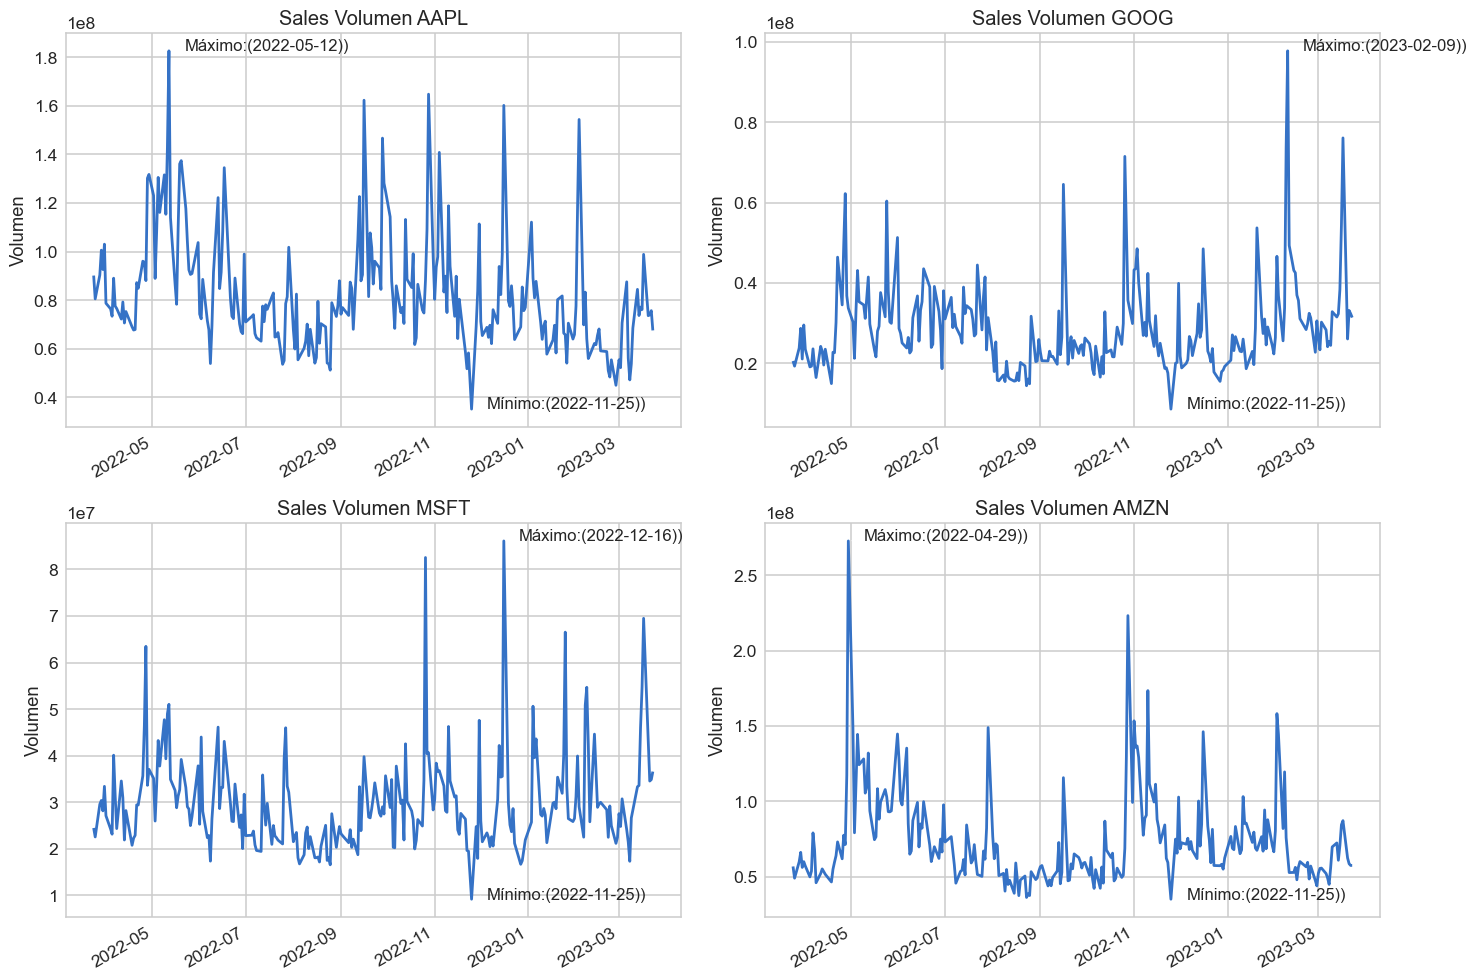

In [9]:
jtplot.style()
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(companies,1):
    ax = plt.subplot(2,2,i)
    company['Volume'].plot(linewidth=2)
    plt.ylabel('Volumen')
    plt.xlabel(None)
    plt.title(f"Sales Volumen {tech_list[i - 1]}")
    
    # Encontrar el valor máximo y su índice correspondiente
    max_value = np.max(company['Volume'])
    max_index = np.argmax(company['Volume'])
    min_value=np.min(company['Volume'])
    min_index = np.argmin(company['Volume'])
    
    # Agregar la etiqueta en el punto máximo
    ax.annotate(f'Máximo:({company.index[max_index].strftime("%Y-%m-%d")}))', 
                xy=(company.index[max_index], max_value),
                xytext=(company.index[max_index] + np.timedelta64(10, 'D'), max_value + 5), 
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=12)
    ax.annotate(f'Mínimo:({company.index[min_index].strftime("%Y-%m-%d")}))', 
                xy=(company.index[min_index], min_value),
                xytext=(company.index[min_index] + np.timedelta64(10, 'D'), min_value + 5), 
                arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=12)

plt.tight_layout()
plt.show()

The moving average (MA)
We use MA to smooth out historical prices and to identify trends.

In [10]:
MA_day = [10, 20, 50]

for x in MA_day:
    for company in companies:
        column_name = f"MA for {x} days"
        company[column_name] = company['Adj Close'].rolling(x).mean()

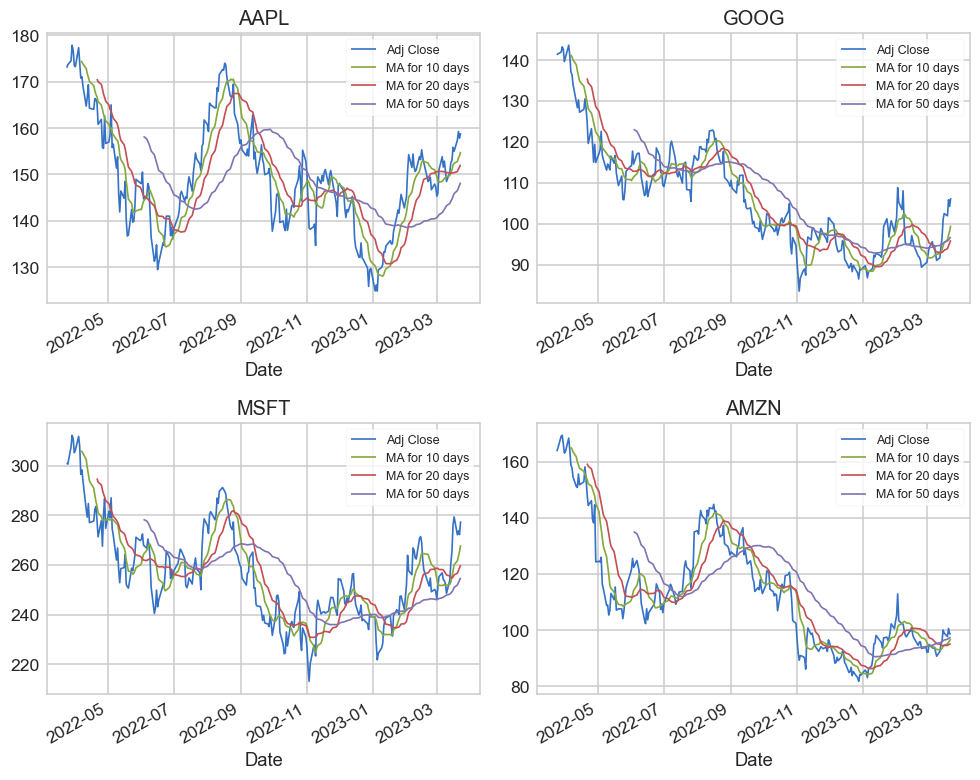

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, company in enumerate(companies):
    ax = axes[i//2, i%2]
    company[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
    ax.set_title(f"{tech_list[i]}")
    ax.legend(loc='upper right',fontsize=9)

plt.tight_layout()
plt.show()

3. What was the daily return of the stock on average?

In [12]:
for company in companies:
    company['Daily Return'] = company['Adj Close'].pct_change()

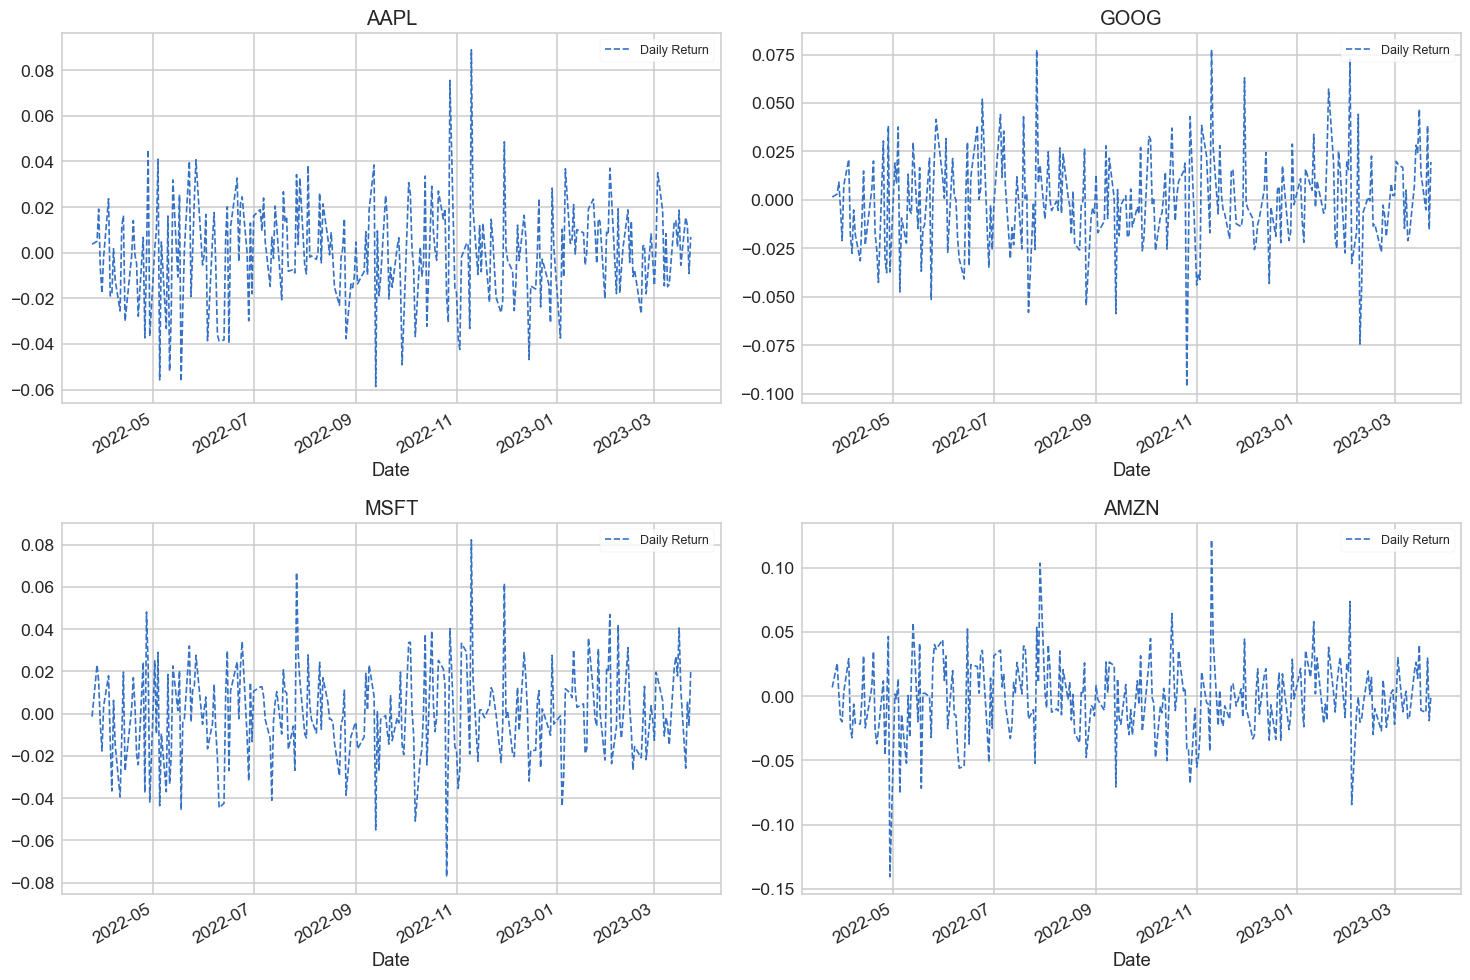

In [13]:
jtplot.style()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i,company in enumerate(companies):
    ax=axes[i//2,i%2]
    company['Daily Return'].plot(ax=ax,linestyle='--')
    ax.set_title(f"{tech_list[i]}")
    ax.legend(loc='upper right',fontsize=9)

plt.tight_layout()
plt.show()

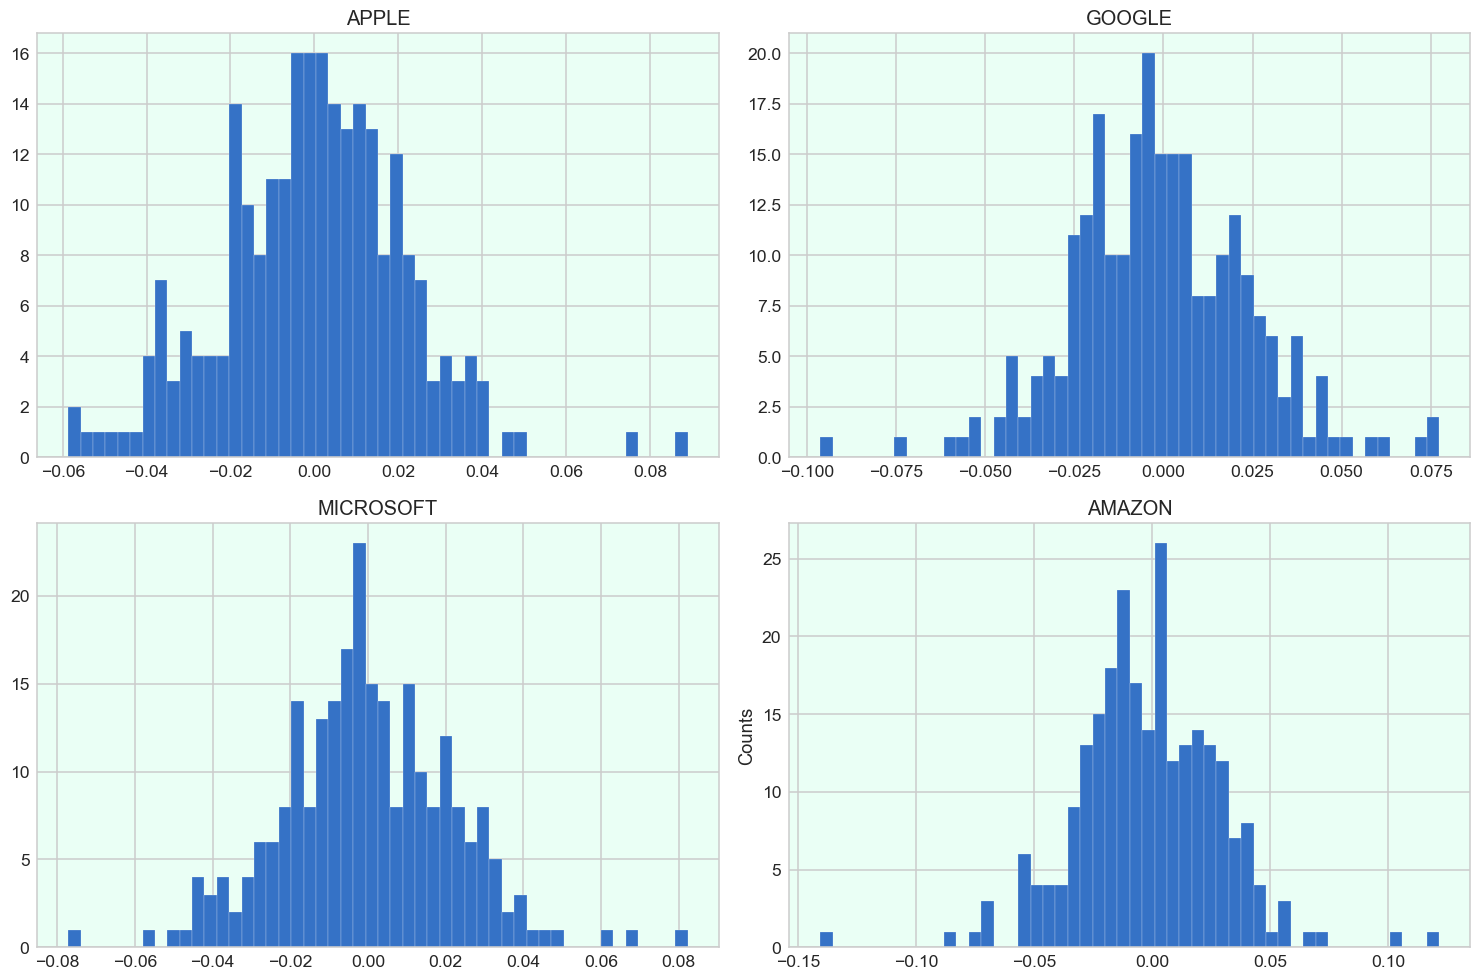

In [14]:
jtplot.style()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i,company in enumerate(companies):
    ax=axes[i//2,i%2]
    company['Daily Return'].hist(ax=ax,bins=50)
    plt.ylabel('Counts')
    ax.set_title(f"{company_name[i]}")
    ax.set_facecolor('#eafff5')

plt.tight_layout()
plt.show()

Is there a linear correlation between stocks?

In [15]:
data_corr=[]
for i in companies:
    data_corr.append(i['Adj Close'])
    
#
data_corr=pd.DataFrame(data_corr)
data_corr=data_corr.transpose()
data_corr.columns=tech_list
    

In [16]:
#returns
data_corr_returns=data_corr.pct_change()


In [17]:
data_corr_returns

,AAPL,GOOG,MSFT,AMZN
Date,,,,
2022-03-24,NaN,NaN,NaN,NaN
2022-03-25,0.003734,0.001483,-0.001381,0.006868
2022-03-28,0.005037,0.003028,0.023116,0.025593
2022-03-29,0.019134,0.009158,0.015159,0.001920
2022-03-30,-0.006650,-0.004227,-0.004914,-0.017801
...,...,...,...,...
2023-03-17,-0.005454,0.013753,0.011694,-0.010896
2023-03-20,0.015484,-0.005173,-0.025767,-0.012532
2023-03-21,0.011944,0.038360,0.005694,0.029680


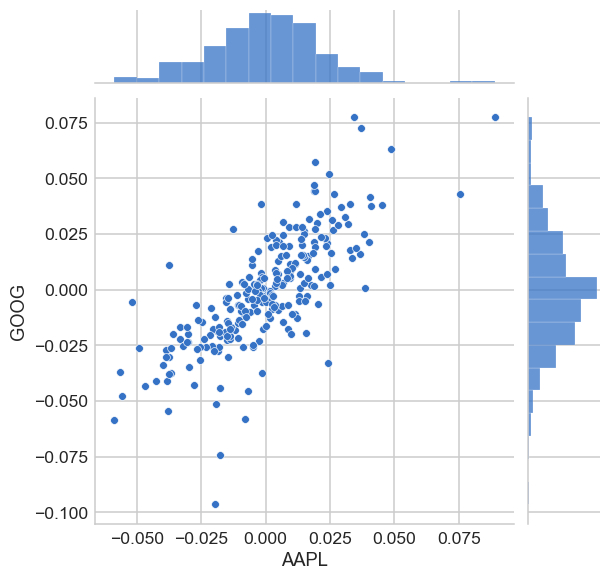

In [18]:
#APPLE vs GOOG

sns.jointplot(x='AAPL',y='GOOG',data=data_corr_returns,kind='scatter')

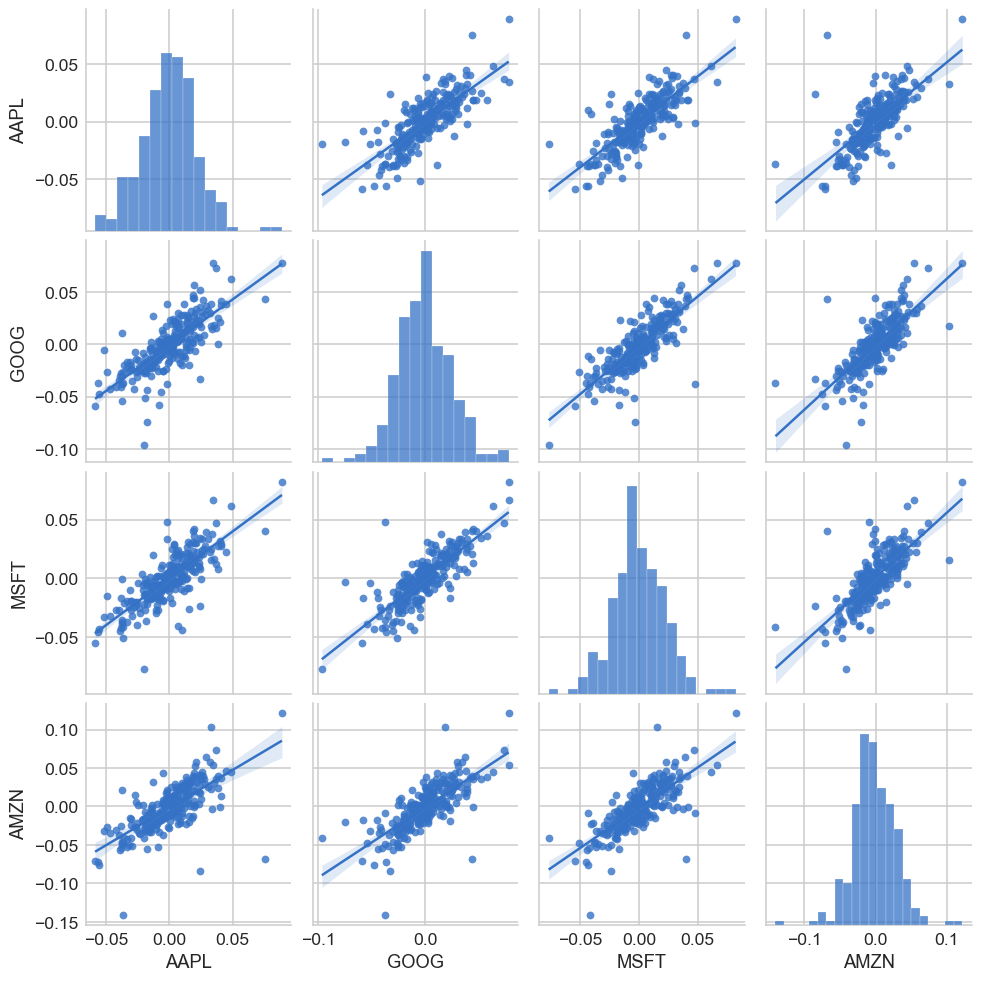

In [19]:
sns.pairplot(data_corr_returns, kind='reg')

Text(0.5, 1.0, 'Correlation of stock closing price')

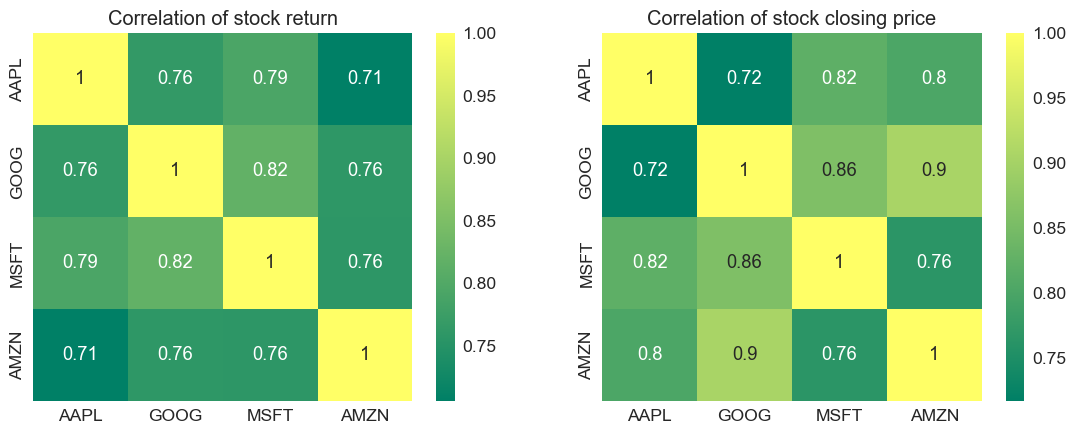

In [20]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(data_corr_returns.corr(numeric_only=True), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(data_corr.corr(numeric_only=True), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

5. How much value do we put at risk by investing in a particular stock?

In [21]:
data_returns=data_corr_returns.dropna()

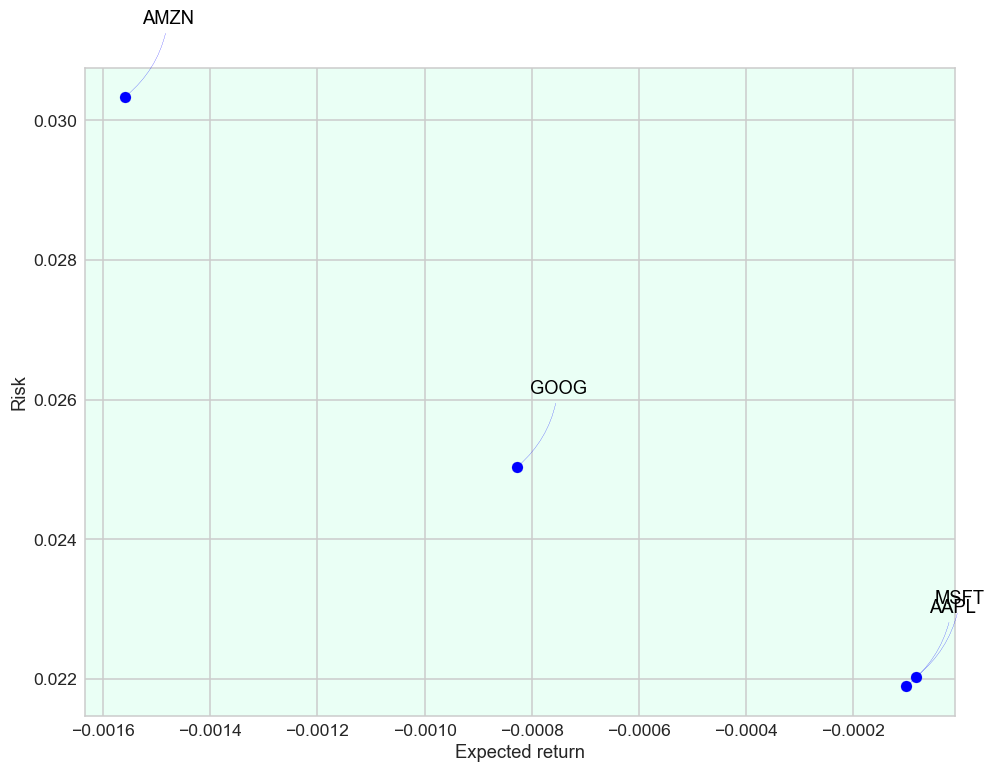

In [22]:
data_returns=data_corr_returns.dropna()
area = np.pi * 20
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_facecolor('#eafff5')
plt.scatter(data_returns.mean(), data_returns.std(), s=area,c="blue")
plt.xlabel('Expected return')
plt.ylabel('Risk')


for label, x, y in zip(data_returns.columns, data_returns.mean(), data_returns.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',color='black', 
arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.2'))

The company data to be analyzed is downloaded

In [23]:
# Google data 
stock=yf.download('GOOG','2012-01-01',end)

[*********************100%***********************]  1 of 1 completed


In [24]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,100.839996,103.489998,100.750000,102.459999,102.459999,76109100
2023-03-20,101.059998,102.580002,100.790001,101.930000,101.930000,26033900
2023-03-21,101.980003,105.959999,101.860001,105.839996,105.839996,33122800
2023-03-22,105.139999,107.510002,104.209999,104.220001,104.220001,32336900
2023-03-23,105.889999,107.100998,105.410004,106.260002,106.260002,31369800


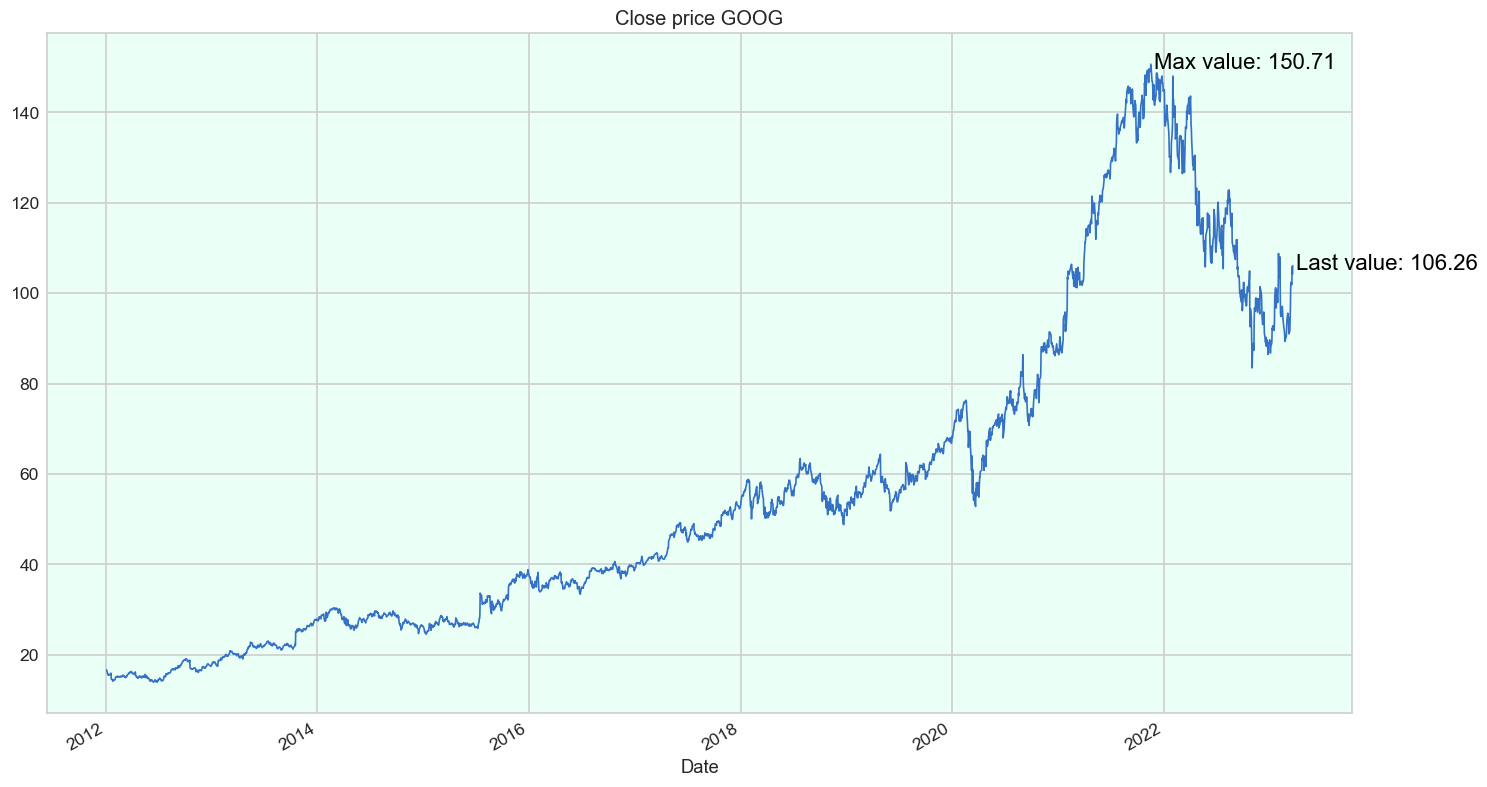

In [25]:
# The data is plotted to observe trends or strange values
fig,ax=plt.subplots(figsize=(15,10))
stock['Close'].plot()
max_value=stock['Close'].max()
max_index=stock['Close'].idxmax()
last_value=stock['Close'][-1]
last_index=stock['Close'].tail(1).idxmax()
ax.set_title('Close price GOOG')
ax.annotate(f'Max value: {max_value:.2f}', 
            xy=(max_index, max_value),
            xytext=(max_index + np.timedelta64(10, 'D'), max_value -1), 
            arrowprops=dict(facecolor='blue', arrowstyle='->'),
            fontsize=16,color='black')
ax.annotate(f'Last value: {last_value:.2f}', 
            xy=(last_index, last_value),
            xytext=(last_index + np.timedelta64(10, 'D'), last_value -1), 
            arrowprops=dict(facecolor='blue', arrowstyle='->'),
            fontsize=16,color='black')
ax.set_facecolor('#eafff5')

plt.show()

In [26]:
stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [27]:
#Only the Close column is selected
stock_close_1=stock.filter(['Close'])
stock_close_1

,Close
Date,
2012-01-03,16.573130
2012-01-04,16.644611
2012-01-05,16.413727
2012-01-06,16.189817
2012-01-09,15.503389
...,...
2023-03-17,102.459999
2023-03-20,101.930000
2023-03-21,105.839996


In [28]:
stock_close=stock_close_1.values
#The data is divided into training and valid
training_data_len = int(np.ceil( len(stock_close) * .9 ))
dif_len=len(stock_close)-training_data_len
dif_len

282

In [29]:
# The data is scaled to normalize the values and also to avoid a large effect of outliers.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_close)

In [30]:
# Creating the training data set 
train_data = scaled_data[0:int(training_data_len), :]
train_data

array([[0.01936668],
       [0.01988927],
       [0.01820133],
       ...,
       [0.94108633],
       [0.94375848],
       [0.91394523]])

In [31]:
# Split the data into x_train and y_train data 
x_train = []
y_train = []

for i in range(dif_len, len(train_data)):
    x_train.append(train_data[i-dif_len:i, 0])
    y_train.append(train_data[i, 0])
    
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [32]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2260/2260 [==============================] - 103s 45ms/step - loss: 9.8367e-04


In [33]:
# Create the testing data set
test_data = scaled_data[training_data_len - dif_len: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = stock_close[training_data_len:, :]
for i in range(dif_len, len(test_data)):
    x_test.append(test_data[i-dif_len:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [34]:
x_test.shape

(282, 282, 1)

In [35]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

9/9 [==============================] - 1s 54ms/step


3.9076826482324334

In [36]:
# Plot the data
valid = stock_close_1[training_data_len:]
valid = pd.DataFrame(valid, columns=['Close'])
valid['Predictions'] = predictions
train = stock_close_1[:training_data_len]

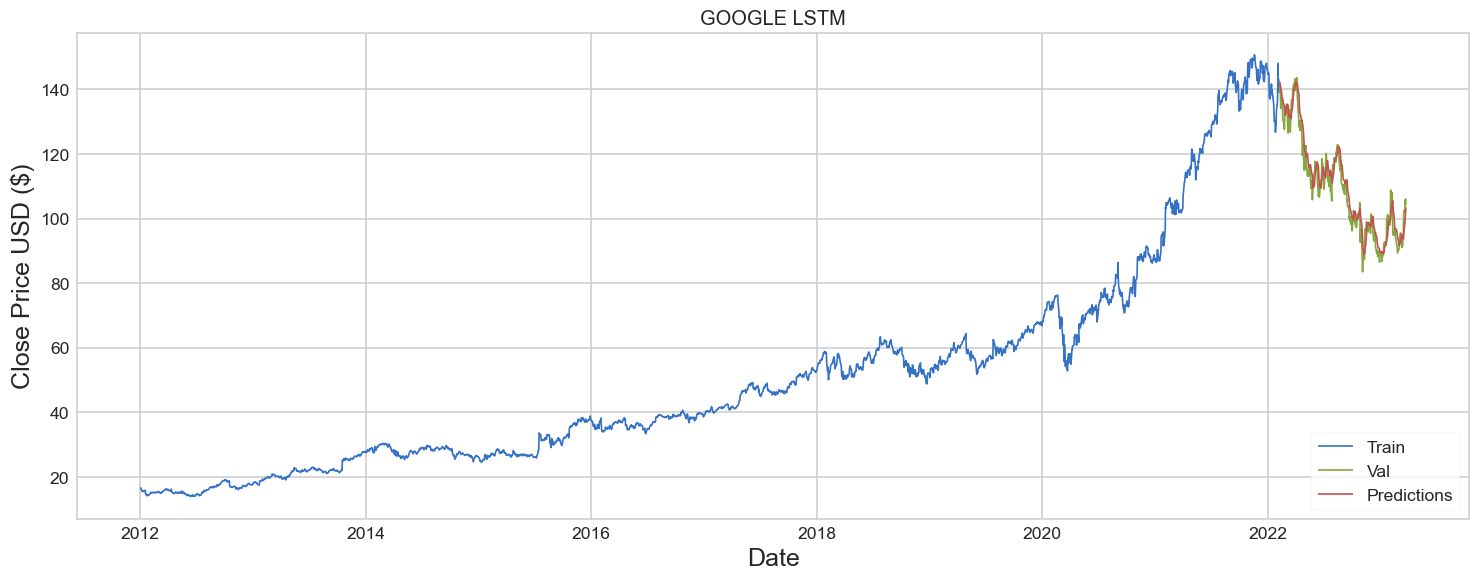

In [37]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('GOOGLE LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

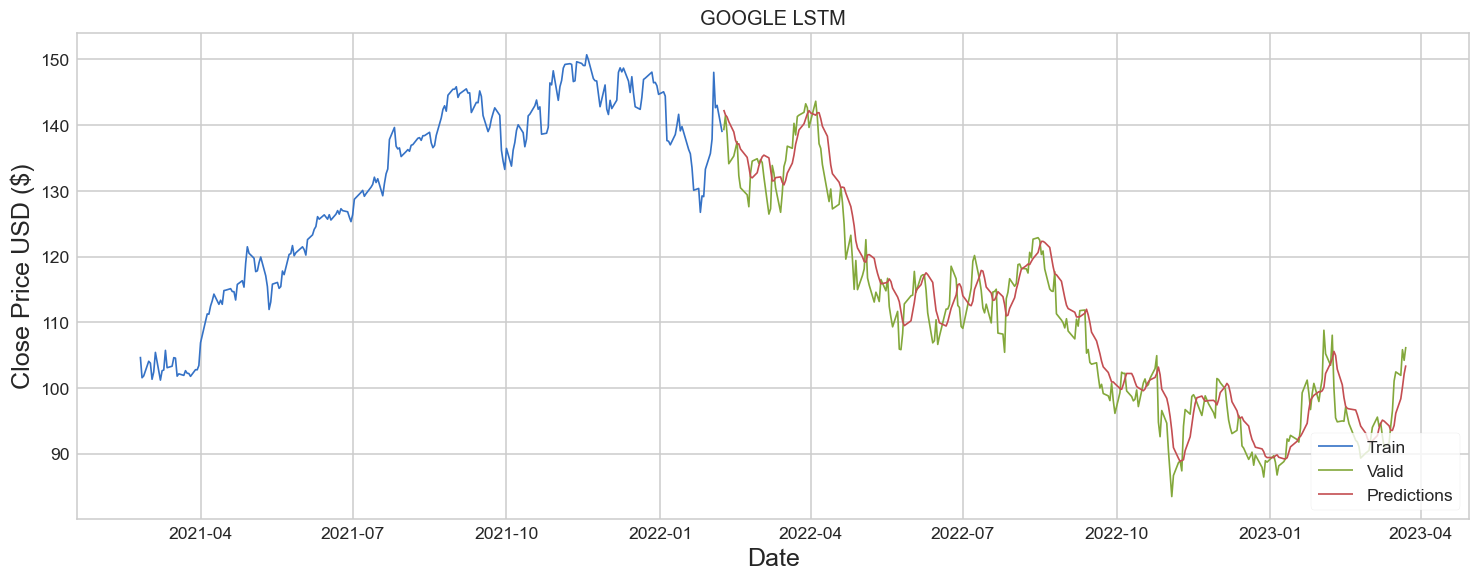

In [38]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('GOOGLE LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][2300:])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

Tomorrow's stock prediction

In [39]:
#Get the latest "dif_len" normalized closing prices
last_dif_len_prices = scaled_data[-dif_len:]

x = np.array([last_dif_len_prices])

# Prediction using the neural network model
prediction_tomorrow = model.predict(x)

# Denormalize the prediction to obtain the value of the action
predicted_price_tomorrow = scaler.inverse_transform(prediction_tomorrow)[0][0]
print(f'The predicted price for tomorrow {datetime.now().strftime("%Y-%m-%d")} is {predicted_price_tomorrow} ')

1/1 [==============================] - 0s 27ms/step
The predicted price for tomorrow 2023-03-24 is 104.60692596435547 
